In [1]:
# A dependency of the preprocessing for BERT inputs
!pip3 install tensorflow-text
!pip install numba
!pip install tf-models-official
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing install

In [7]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import pandas as pd
import matplotlib.pyplot as plt



NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt


      Unzipping tokenizers/punkt.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
reviews = pd.read_csv('yelp_labelled.csv')
reviews = reviews.astype({'Text':'string'})

# New section

In [10]:
reviews.shape

(1000, 2)

In [11]:
reviews['Sentiment'].value_counts()

1    500
0    500
Name: Sentiment, dtype: int64

In [12]:
reviews.head()

,Text,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [14]:
#may be worth shuffeling the data to prevent any ordering having an influence on the performance

reviews = reviews.sample(frac=1, random_state=1)
reviews.reset_index(drop=True, inplace=True)


In [15]:
reviews.head()

,Text,Sentiment
0,My gyro was basically lettuce only.,0
1,It kept getting worse and worse so now I'm off...,0
2,I am far from a sushi connoisseur but I can de...,0
3,"The staff are great, the ambiance is great.",1
4,By this time our side of the restaurant was al...,0


In [17]:
from sklearn.model_selection import train_test_split

#split and take the test set
X, X_test, y, y_test = (train_test_split(reviews['Text'], reviews['Sentiment'],
                                                     stratify=reviews['Sentiment'],
                                                     test_size=0.2,
                                                     train_size=0.8
                                                     ))



In [18]:

#split the train set (X) into train and validation
X_train, X_val, y_train, y_val = (train_test_split(X, y,
                                                     stratify=y,
                                                     test_size=0.25,
                                                     train_size=0.75
                                                     ))


In [19]:
X_train

796      I don't think we'll be going back anytime soon.
421    Probably never coming back, and wouldn't recom...
938                         After two I felt disgusting.
323    I went to Bachi Burger on a friend's recommend...
577    It was attached to a gas station, and that is ...
                             ...                        
307    Delicious NYC bagels, good selections of cream...
58     They had a toro tartare with a cavier that was...
110                                          I LOVED it!
414    This place is not quality sushi, it is not a q...
321    It was either too cold, not enough flavor or j...
Name: Text, Length: 600, dtype: string

In [20]:
X_val

40     All in all an excellent restaurant highlighted...
197    I really do recommend this place, you can go w...
216    On the good side, the staff was genuinely plea...
691                              Fantastic service here.
893    (It wasn't busy either) Also, the building was...
                             ...                        
847                But now I was completely grossed out.
895         All I have to say is the food was amazing!!!
203          The burger is good beef, cooked just right.
988    Definitely worth venturing off the strip for t...
906    the staff is friendly and the joint is always ...
Name: Text, Length: 200, dtype: string

In [21]:
X_test

972    The owner used to work at Nobu, so this place ...
3            The staff are great, the ambiance is great.
936     The food is very good for your typical bar food.
258                                     Worst Thai ever.
584                                     It was not good.
                             ...                        
834    Hawaiian Breeze, Mango Magic, and Pineapple De...
60     As much as I'd like to go back, I can't get pa...
903    This place is hands-down one of the best place...
432    They brought a fresh batch of fries and I was ...
456    Service is quick and even "to go" orders are j...
Name: Text, Length: 200, dtype: string

In [22]:
#@title Choose a BERT model to fine-tune

#the model has 5 layers (L), 512 hidden size H and 8 attention heads
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'


map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [23]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [24]:
reviews['Text'][0]

'My gyro was basically lettuce only.'

In [25]:
text_test = ["This was a superb episode, one of the best of both seasons. Down right horror for a change, with a story that is way way above the average MOH episodes, if there is such a thing. A man's wife is almost burned to death in a tragic car wreck, in which he was driving. His airbag worked, her's didn't. She is burned beyond recognition (great makeup btw), and not given much of a chance to live without a full skin graft. BUT, even in a coma, she keeps dying but brought back by modern technology, and when she does die for a few minutes, her ghost appears as a very vengeful spirit. Carnage of course ensues, and also some extremely gory killings, and also, some extremely sexy scenes. What more could you ask for, you might ask? Well, not much, because this baby has it all, and a very satirical ending, that should leave a smile on most viewers faces. I just loved Rob Schmidt's (Wrong Turn) direction too, he has a great knack for horror. Excellent episode, this is one I'm buying for sure.This was a superb episode, one of the best of both seasons."]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2023  2001  1037 21688  2792  1010  2028  1997  1996  2190  1997]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [26]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [27]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.69012964  0.9975627  -0.3208748   0.03474536  0.61504745 -0.9180392
  0.9794196  -0.8541881  -0.55359995 -0.99389905 -0.1427725  -0.9524567 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.0188163  -0.19083843  0.3050597  ... -0.81572354 -0.21436548
   0.44432908]
 [-0.51914185  0.05107647 -0.33874914 ...  1.2194271  -0.7392851
   0.8853786 ]
 [-0.45957777  0.15729158 -0.8944282  ...  0.89337957 -0.33719885
   0.5819469 ]
 ...
 [-0.50319046  0.23234269 -2.4240856  ... -1.0548147   0.7751127
  -0.3609869 ]
 [-1.4614183   0.20342314 -0.8485447  ... -0.09167176 -0.07505923
  -0.01238827]
 [-1.6349413   0.33674482 -1.0467947  ...  0.22726588 -0.93820596
  -0.2424231 ]]


In [28]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  #net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [29]:
classifier_model = build_classifier_model()

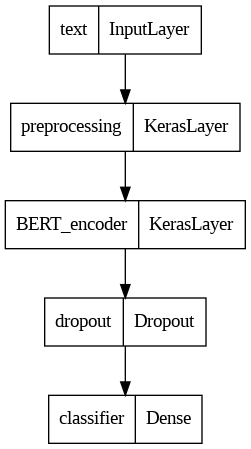

In [30]:
tf.keras.utils.plot_model(classifier_model)

In [31]:
epochs = 10
steps_per_epoch = 1200  #corresponding to the train set size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps) #10% of num_train_steps

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [32]:
#fine-tune BERT for classification
classifier_model.compile(optimizer,
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=[tf.keras.metrics.BinaryAccuracy()])
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

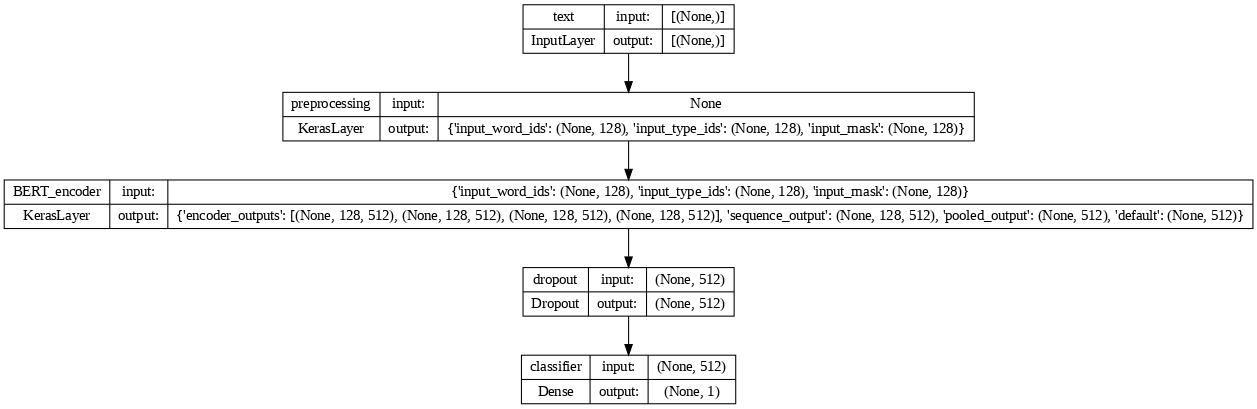

In [33]:
tf.keras.utils.plot_model(model=classifier_model,show_shapes=True,dpi=76)

In [34]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train,
                               y_train,
                               validation_data=(X_val, y_val),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 226s 12s/step - loss: 0.7105 - binary_accuracy: 0.4917 - val_loss: 0.7046 - val_binary_accuracy: 0.5450
Epoch 2/10
19/19 [==============================] - 183s 10s/step - loss: 0.7097 - binary_accuracy: 0.5100 - val_loss: 0.6942 - val_binary_accuracy: 0.5350
Epoch 3/10
19/19 [==============================] - 175s 9s/step - loss: 0.6888 - binary_accuracy: 0.5317 - val_loss: 0.6771 - val_binary_accuracy: 0.5850
Epoch 4/10
19/19 [==============================] - 176s 9s/step - loss: 0.6740 - binary_accuracy: 0.5767 - val_loss: 0.6551 - val_binary_accuracy: 0.6000
Epoch 5/10
19/19 [==============================] - 178s 9s/step - loss: 0.6534 - binary_accuracy: 0.6250 - val_loss: 0.6321 - val_binary_accuracy: 0.6450
Epoch 6/10
19/19 [==============================] - 187s 10s/step - loss: 0.6265 - binary_accuracy: 0.6567 - val_loss: 0.6053 - val_binary_accuracy: 0.7300
Epoch 7/10
19/19 [==============================] - 176s 9s/step - loss: 0.599

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


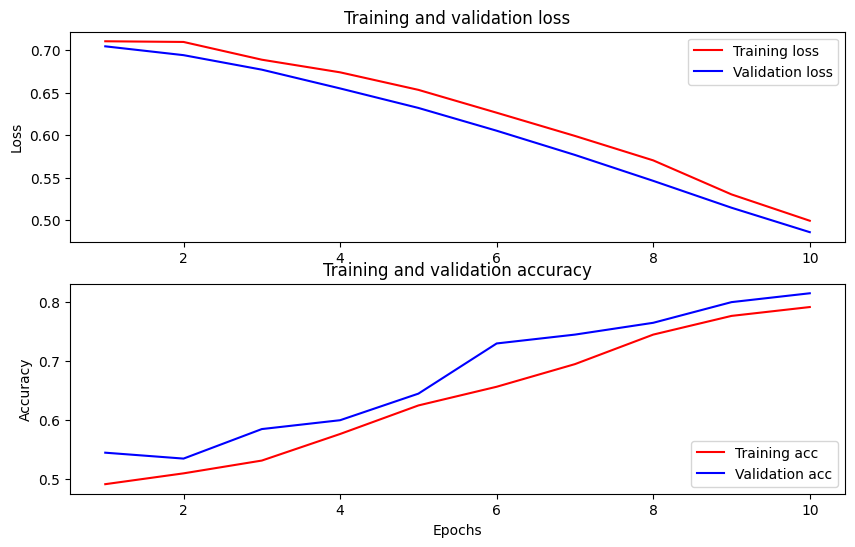

In [35]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [36]:
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

7/7 [==============================] - 15s 2s/step - loss: 0.5125 - binary_accuracy: 0.7750
Loss: 0.5125213861465454
Accuracy: 0.7749999761581421


In [37]:
#performance metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#predicted values using the model
y_pred=classifier_model.predict(X_test)

print(y_pred.flatten())

7/7 [==============================] - 15s 2s/step
[0.2312221  0.85185885 0.8608191  0.30675387 0.17500146 0.4172564
 0.38877642 0.18500066 0.61525744 0.72209024 0.5338696  0.34675243
 0.6005941  0.6517224  0.43375903 0.14151146 0.32207048 0.7117647
 0.30113307 0.1575668  0.5721854  0.6359201  0.2770381  0.19187225
 0.70959675 0.81063753 0.2779007  0.69105107 0.7542173  0.8464092
 0.46654204 0.5468022  0.77797616 0.6292847  0.8421033  0.5095805
 0.4263049  0.18259004 0.34091064 0.5464356  0.3314294  0.27527985
 0.3421156  0.80775577 0.5083637  0.8020017  0.6821094  0.21335341
 0.7552022  0.3597707  0.2615927  0.17641412 0.15413024 0.31337932
 0.78545916 0.7347296  0.16725324 0.66996974 0.6039149  0.57091606
 0.19526115 0.37607735 0.5135466  0.8704315  0.12772848 0.38260517
 0.3741296  0.67915255 0.80860955 0.4818247  0.26947233 0.30523726
 0.13745718 0.79461604 0.8692655  0.42323548 0.33016258 0.74077296
 0.3136915  0.25994924 0.15591772 0.53374845 0.84214246 0.16379297
 0.81272095 0.2

In [38]:
#len(y_pred)

for i in range(len(y_pred)):
  if y_pred[i]<0.5:
    y_pred[i] = 0
  else: y_pred[i] = 1

print(y_pred.flatten())

[0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 1.]


In [39]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score
import seaborn as sns

def plot_roc_auc(y, y_pred):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if title:
        plt.title(title)
    plt.show()

[[79 21]
 [24 76]] 

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       100
           1       0.78      0.76      0.77       100

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.77       200

Accuracy: 0.775
AUC: 0.775
F1: 0.7715736040609137


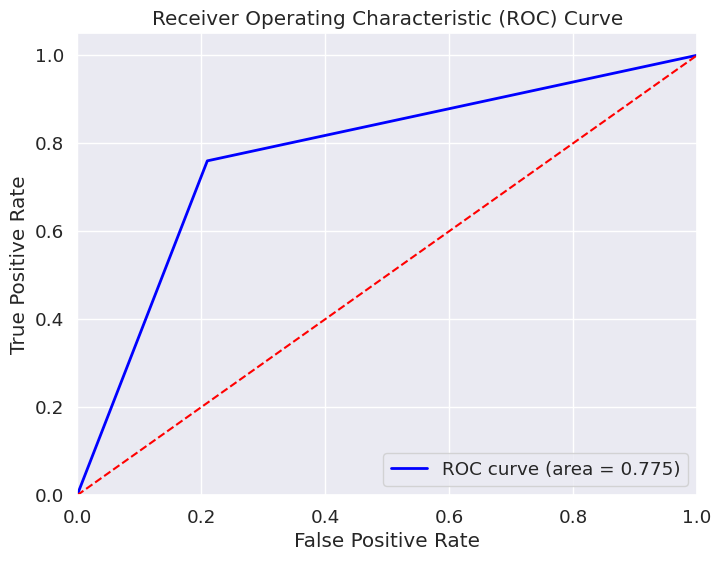

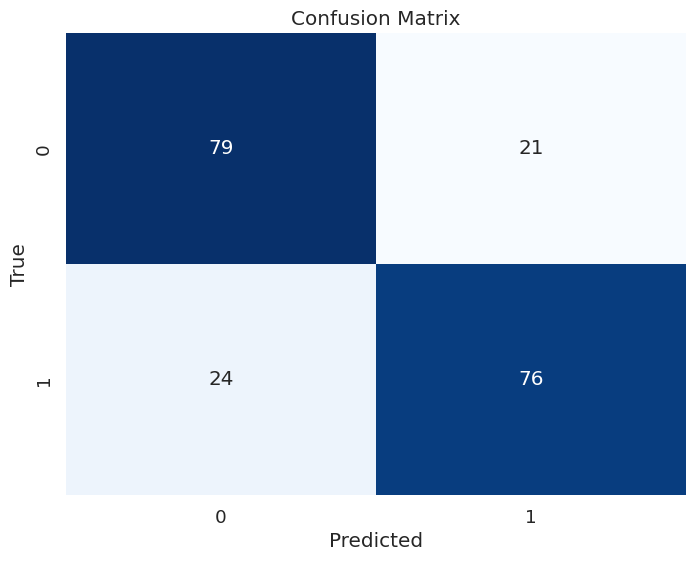

In [45]:


#print(confusion_matrix(y_test, y_pred), '\n')
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
plot_roc_auc(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, classes=sorted(y.unique().tolist()), title='Confusion Matrix')